# A/B Testing Project

## Contents 
<a name="back"></a>

1. [Introduction](#introduction)
2. [Part 1: Prioritizing Hypotheses](#hypotheses)
   1. [Data loading and inspection](#data1)
   2. [ICE](#ice)
   3. [RICE](#rice)
3. [Part 2. A/B Test Analysis](#ab_test)
    1. [Cumulative revenue](#cum_revenue)
    2. [Cumulative order size](#cum_avg_order_size)
    3. [Avg order size relative difference](#diff_cum_avg_order_size)
    4. [Conversion rates](#conversion_rates)
    5. [Orders per user](#orders_per_user)
    6. [Percentiles of orders per user](#perc_orders_per_user)
    7. [Order prices](#order_sizes)
    8. [Order prices percentiles](#order_prices_perc)
    9. [Raw conversion difference significance](#raw_conversion_difference_significance)
    10. [Significance of raw difference in average order sizes](#significance_raw_difference_order_size)
    11. [Significance of filtered difference in conversion](#"significance_filtered_difference_in_conversion")
    12. [Statistical significance of the difference of average orders using filtered data](#significance_avg_check_filtered)
4. [Conclusion](#final_decision)
        

## Introduction
<a name="introduction"></a>

This proyect is for the A/B Testing sprint on Tripleten's Data Analyst course. It consists on two parts:

- Part 1 - Prioritizing hypotheses: We have a list of hypotheses that we need to prioritize according to ICE and RICE, and draw conclusions.
- Part 2 - A/B Test Analysis: For this part we have data on visitors and orders. Our objective is to determine the results of the test.

For this project we'll be using the following:
- Python 3.9.5
- Pandas 1.2.4
- Matplotlib.pyplot 3.3.4
- Numpy 1.20.3
- Scipy.stats 1.7.3

Versions were chosen so they match as closely as possible the versions available on the Tripleten servers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import datetime as dt
import math

## Part 1: Prioritizing Hypotheses
<a name="hypotheses"></a>

### Data loading and inspection
<a name="data1"></a>

We have a table with the current hypotheses that are awaiting testing. We'll have to load several tables for this proyect, so lets create a function to acomplish that.

In [2]:
def load_csv(path: str, sep: str):
    try: # Local path
        filepath = f'datasets/{path}'
        df = pd.read_csv(filepath, sep=sep)
    except: # Tripleten server path
        filepath = f'/datasets/{path}'
        df = pd.read_csv(filepath, sep=sep)
    return df

Now we need to load the table and see what it contains. This is a short table.

In [3]:
# Load the table
hypotheses = load_csv('hypotheses_us.csv', ';')

In [4]:
hypotheses.columns = [x.lower().replace(' ', '_') for x in hypotheses.columns]

In [5]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


There is only 9 hypotheses. Lets see them.

In [6]:
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


There isn't any preprocessing to be done with this. It's ready to be used.

[Back to Contents](#back)

### ICE
<a name="ice"></a>

The ICE score is calculated like this: `(Impact * Confidence) / Effort`. Lets add an ICE column to the data.

In [7]:
hypotheses['ICE'] = hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']

In [8]:
hypotheses.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,effort,ICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000


The ICE score is placing hypotheses 8, 0 and 7 in the top place. These are the following:

- 8: Launch a promotion that gives users discounts on their birthdays
- 0: Add two new channels for attracting traffic. This will bring 30% more users
- 7: Add a subscription form to all the main pages. This will help you compile a mailing list

These all have top scores in Impact and Confidence, with a medium Effort score.

Lets see how that changes with RICE.

[Back to Contents](#back)

### RICE <a name="rice"></a>

Similar to ICE, RICE will give us a score that will let us prioritize our hypotheses. This time we add Reach to the equation:

`(Reach * Impact * Confidence) / Effort`

Lets calculate it and add it to the table.

In [9]:
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

In [10]:
hypotheses.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


The RICE score also puts hypotheses 7 and 0 in the top 3. 

- Hypotheses 7 already had a high ICE score. Having maximum reach bumped it's position to the first place, by far. It has more than double the score of the next best.
- Hypotheses 2 was in the middle of the pack according to ICE. It has a good Reach score, which helped it move up. But the main reason it got to second place is that the rest of the ICE high scorers have a pretty low Reach, drastically impacting their RICE score.
- Hypotheses 8 was knocked down several positions due to its low reach.
- Hypotheses 0 had a great ICE score, and with that it managed to stay in the top 3 even tough it has a low Reach score, mostly because that is the case with most of the hypotheses.

Overall, hypotheses 7 seems to be the most relevant right now.

[Back to Contents](#back)

## Part 2: A/B Test Analysis <a name="ab_test"></a>

For this part we have the data of the A/B test. We will be analizing the results in order to conclude if the tested hypotheses show an improvement or not. 

### Data loading and inspection <a name="data2"></a>

We have two tables to work with here. Visitors and Orders. Let's get them ready.

In [11]:
orders = load_csv('orders_us.csv', ',')
visits = load_csv('visits_us.csv', ',')

In [12]:
orders.info()
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


It has no null values, and the column names are correctly formatted. We need to set the proper types for the date and group.

In [13]:
# Set date and group to their correct type
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['group'] = orders['group'].astype('category')

Now lets do the same for visits.

In [14]:
visits.info()
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


There is no null values. Column names are ok. We only need to correct the types.

In [15]:
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits['group'] = visits['group'].astype('category')

Now lets check some possible errors in the data:

Do we have repeated `date-group` combinations in `visits`?

In [16]:
# Check for rows with the same date-group combination. A sum of 0 mean there are no duplicates
visits[['date', 'group']].duplicated().sum()

0

Do we have duplicated `transactionId`'s?

In [17]:
# There are 1197 rows in the orders df. We should get the same value with nunique if there isn't any duplicates
orders['transactionId'].nunique()

1197

Do the `date` range match in `orders` and `visits`?

In [18]:
# The min and max values should match
print('Orders date range:')
print(orders['date'].min())
print(orders['date'].max())
print('---')
print('Visits date range:')
print(visits['date'].min())
print(visits['date'].max())

Orders date range:
2019-08-01 00:00:00
2019-08-31 00:00:00
---
Visits date range:
2019-08-01 00:00:00
2019-08-31 00:00:00


Is there a value other than A and B in the group columns?

In [19]:
print(orders['group'].unique())
print(visits['group'].unique())

['B', 'A']
Categories (2, object): ['A', 'B']
['A', 'B']
Categories (2, object): ['A', 'B']


Is there a size difference between groups?

In [20]:
visits.groupby('group')['visits'].sum()

group
A    18736
B    18916
Name: visits, dtype: int64

In [21]:
18736/18916

0.9904842461408332

Group B has around 1% more visits than group A. Lets remember this.

Does any `visitorId` have orders on both groups?

In [22]:
double_groups = orders.groupby('visitorId')['group'].nunique().sort_values(ascending=False).reset_index().query('group > 1')
double_groups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   visitorId  58 non-null     int64
 1   group      58 non-null     int64
dtypes: int64(2)
memory usage: 1.4 KB


There are 58 visitors that were part of both groups. We should drop them from the test. It is possible to drop their orders, but we have no way of droping their visits, since we only have pre-agregated data.

In [23]:
orders = orders[np.logical_not(orders['visitorId'].isin(double_groups['visitorId']))]

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 40.8 KB


The data is ready for work. Let's start.

[Back to contents](#back)

### Cumulative revenue
<a name="cum_revenue"></a>

Let's start by plotting the cumulative revenue by group. 

In [25]:
# Since we changed groups to category, we can't use max anymore. We'll use this function instead
def get_group(col):
    return col.iloc[0]

In [26]:
# We already checked that there are no duplicates here
datesGroups = visits[['date', 'group']]

# Calculate the cumulative values per day for each group
cumulativeData = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'],
            orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': get_group,
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum'
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

# Calculate the cumulative visits
cumulativeVisits = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'],
            visits['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': get_group,
            'visits': 'sum'
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])
cumulativeVisits.columns = ['date', 'group', 'visits']

# Merge the cumulative data
cumulativeData = cumulativeData.merge(
    cumulativeVisits,
    on=['date', 'group']
)


In [27]:
cumulativeRevenueA = (cumulativeData.query('group == "A"'))[['date', 'revenue', 'orders']]
cumulativeRevenueB = (cumulativeData.query('group == "B"'))[['date', 'revenue', 'orders']]

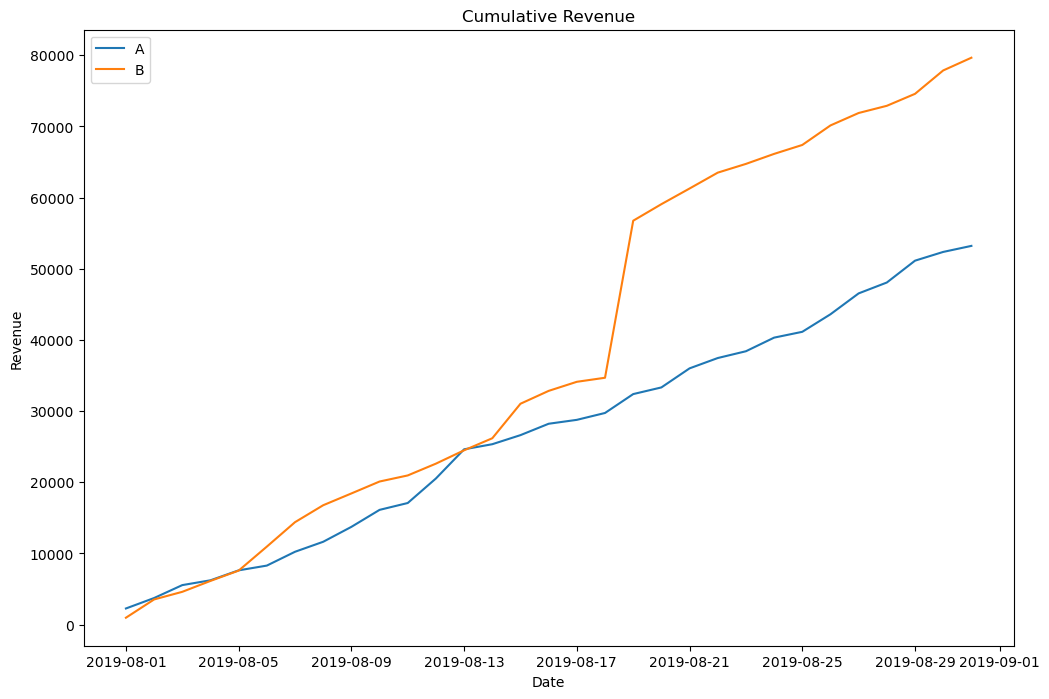

In [60]:
plt.figure(figsize=(12,8))
plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue'],
         label="A"
        )
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue'],
         label="B"
        )

plt.title('Cumulative Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend();

Group B appears to take the lead on revenue. The big jump suggests the presence of outliers. We'll have to check that later.

[Back to Contents](#back)

### Cumulative avg order size
<a name="cum_avg_order_size"></a>

Now lets see how the average order size evolved during the test.

In [29]:
cumulativeRevenueA['avg_order_size'] = cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders']
cumulativeRevenueB['avg_order_size'] = cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders']

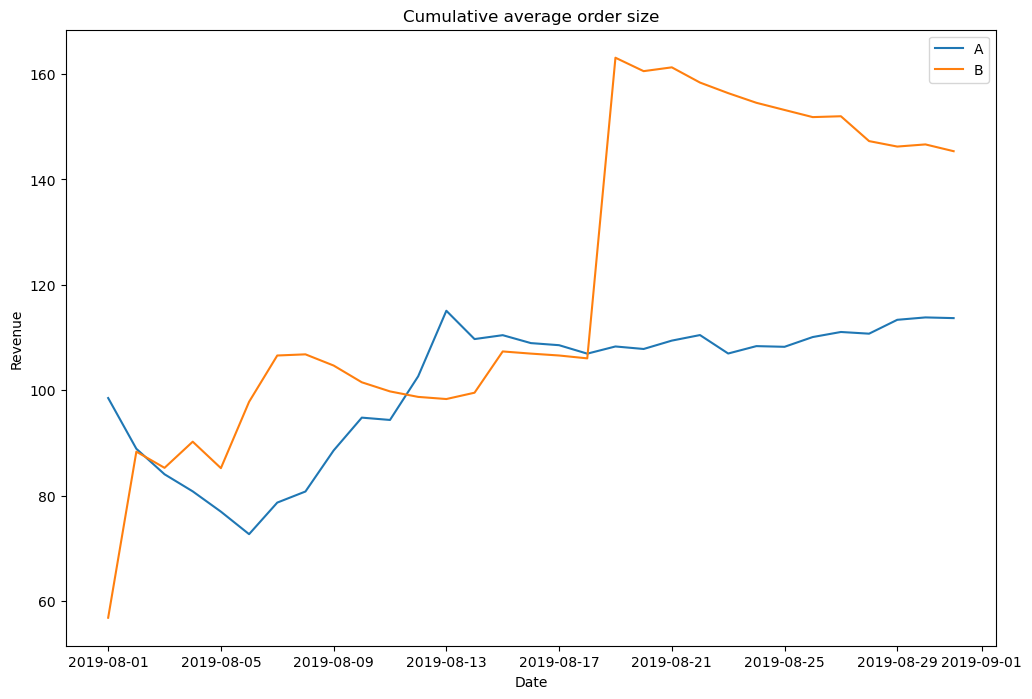

In [73]:
plt.figure(figsize=(12,8))
plt.plot(
    cumulativeRevenueA['date'],
    cumulativeRevenueA['avg_order_size'],
    label = 'A'
)

plt.plot(
    cumulativeRevenueB['date'],
    cumulativeRevenueB['avg_order_size'],
    label = 'B'
)
plt.title('Cumulative average order size')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend();

Just as before, we see a huge jump on group B. We'll need to remove outliers to properly analyze this data.

[Back to Contents](#back)

### Relative difference in cumulative avg order size
<a name="diff_cum_avg_order_size"></a>

In [31]:
cumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    on=['date'],
    suffixes=['A', 'B']
)

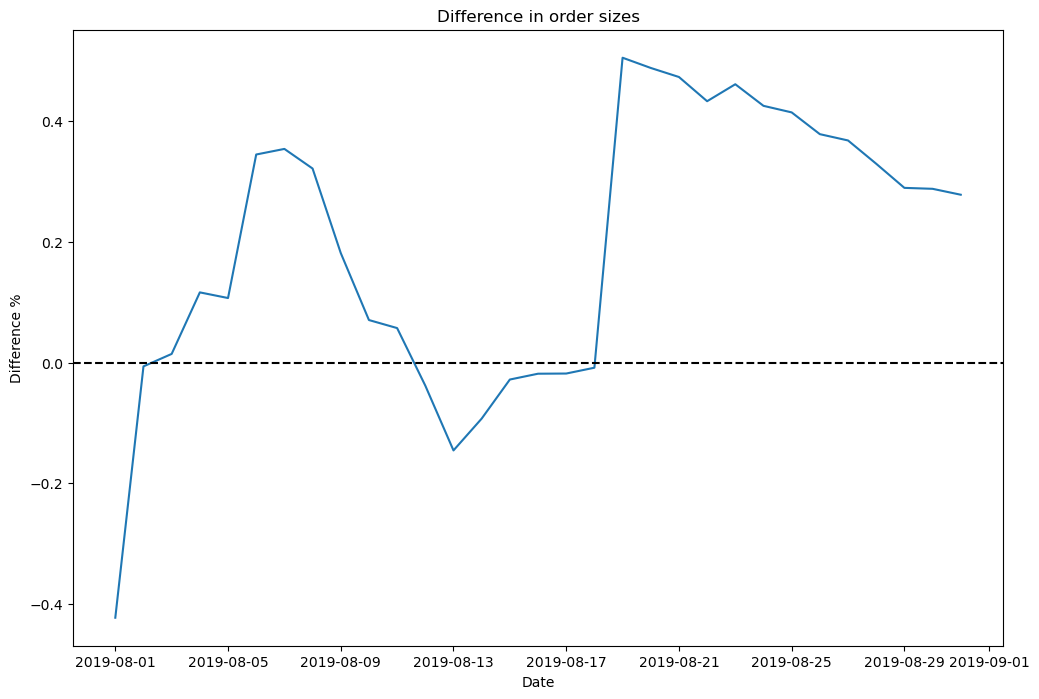

In [77]:
plt.figure(figsize=(12,8))
plt.plot(cumulativeRevenue['date'],
         (cumulativeRevenue['avg_order_sizeB'] / cumulativeRevenue['avg_order_sizeA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Difference in order sizes')
plt.xlabel('Date')
plt.ylabel('Difference %');

The graph shows both groups alternating their leads. TB is on the top for now, thanks to the large jump, but seems to be moving lower and it hasn't stabilized yet. Once we remove the outliers it'll be more clear.

[Back to Contents](#back)

### Conversion rates
<a name="conversion_rates"></a>

Let's see how the groups compare when it comes to conversion rates. We'll calculate it as `orders / visits`.

In [33]:
conversionA = cumulativeData.query('group == "A"')[['date', 'orders', 'visits']]
conversionB = cumulativeData.query('group == "B"')[['date', 'orders', 'visits']]

conversionA['conversion'] = conversionA['orders'] / conversionA['visits']
conversionB['conversion'] = conversionB['orders'] / conversionB['visits']

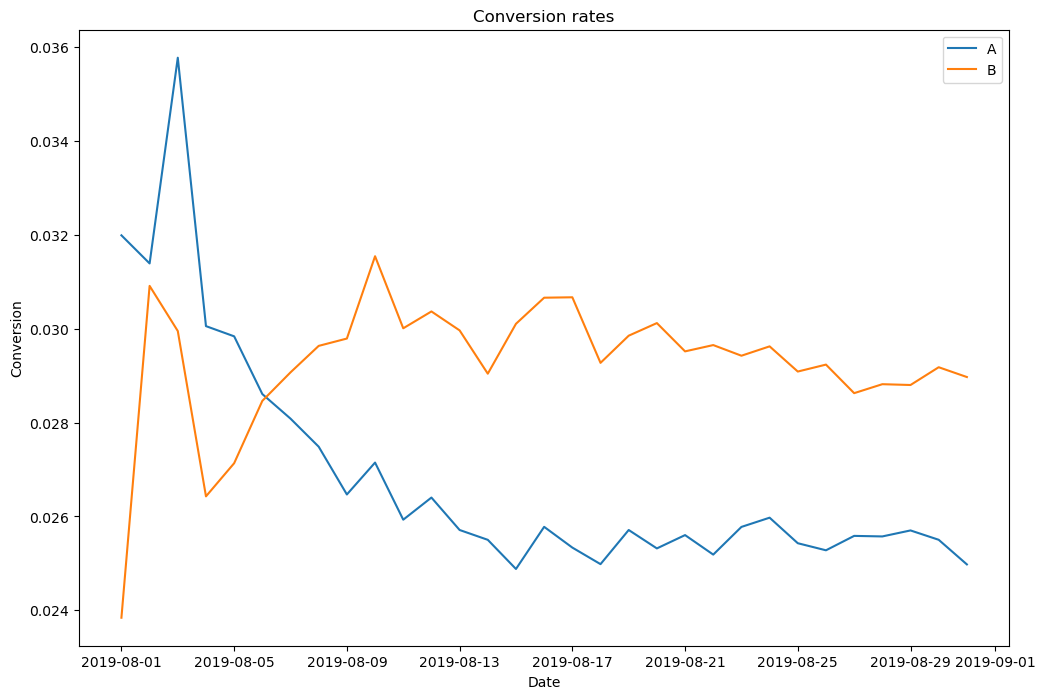

In [64]:
plt.figure(figsize=(12,8))
plt.plot(
    conversionA['date'],
    conversionA['conversion'],
    label='A'
)
plt.plot(
    conversionB['date'],
    conversionB['conversion'],
    label='B'
)
plt.title('Conversion rates')
plt.xlabel('Date')
plt.ylabel('Conversion')
plt.legend();


Group B seems to have an advantage. Group A is stabilizing around 0.25, while group B is near 0.3.

Lets see the difference.

In [35]:
conversion = conversionA.merge(
    conversionB,
    on='date',
    suffixes=['A', 'B']
)

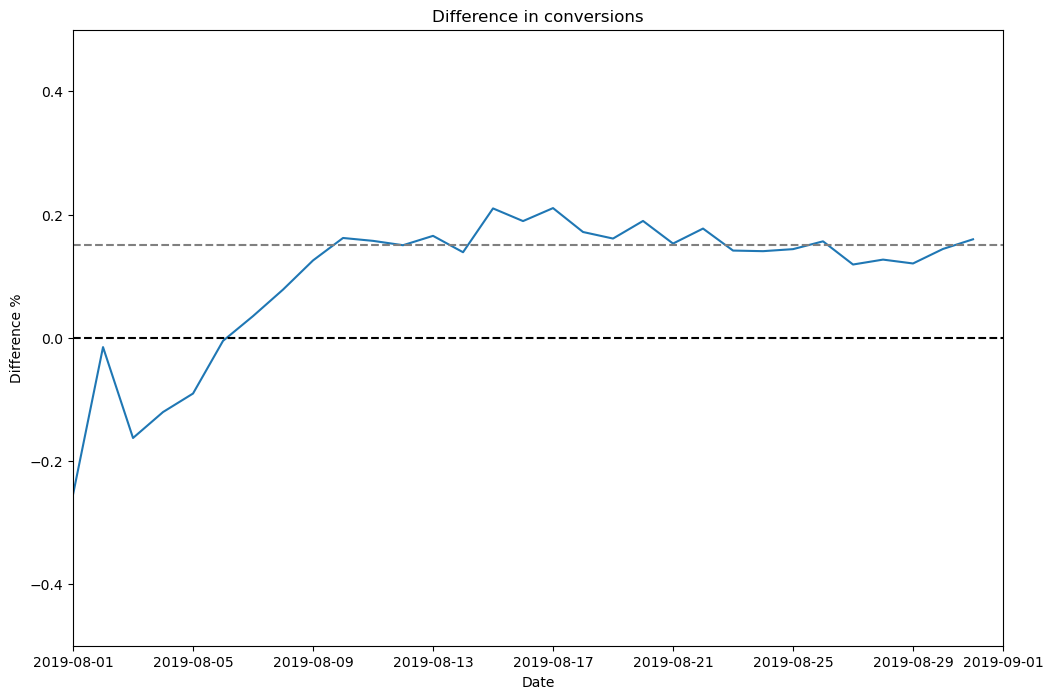

In [76]:
plt.figure(figsize=(12,8))
plt.plot(
    conversion['date'],
    (conversion['conversionB'] / conversion['conversionA'])-1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='gray', linestyle='--')
plt.axis([dt.datetime.strptime("2019-08-01", format), dt.datetime.strptime('2019-09-01', format), -0.5, 0.5])
plt.title('Difference in conversions')
plt.xlabel('Date')
plt.ylabel('Difference %');

Conversion looks stable at around 15% in favor of group B.

[Back to contents](#back)

### Orders per user
<a name="orders_per_user"></a>

Let's shift now towards number of orders. How many orders does the average user place in a month?

In [37]:
orders_per_user = (
    orders.groupby('visitorId', as_index=False)
    .agg(
        {
            'transactionId': pd.Series.nunique,
            'group': get_group
        }
    )
) 
orders_per_user.columns = ['id', 'orders', 'group']

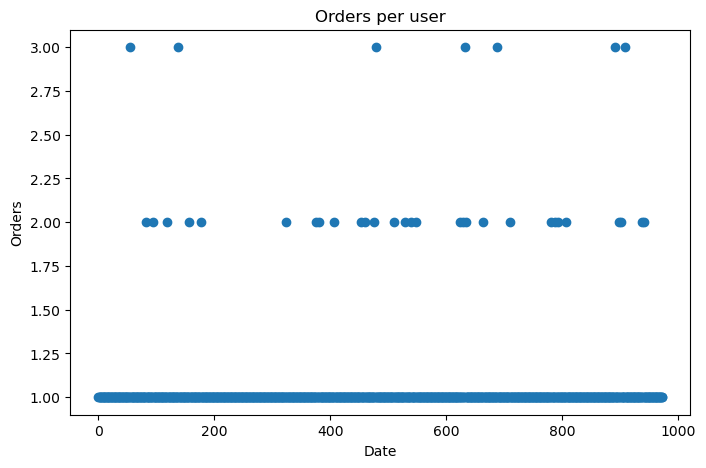

In [66]:
index = np.arange(len(orders_per_user))

plt.figure(figsize=(8,5))
plt.scatter(
    index,
    orders_per_user['orders']
)
plt.title('Orders per user')
plt.xlabel('Date')
plt.ylabel('Orders');

It's clear that the large mayority of users place one order in a month. Three orders in a month is a rarity.

Still, there are no users with an abnormally large amount of orders during the test.

[Back to Contents](#back)

### Percentiles of orders per user
<a name="perc_orders_per_user"></a>

Percentiles are usually an excelent tool to define outliers. There really aren't any extreme values in this case.
Still, let's find the 95th and 99th percentile for amount of orders per user.

In [39]:
np.percentile(orders_per_user['orders'], [95, 99])

array([1., 2.])

95% of users make one order at most.
Less than 1% of users make more than 3 orders.

However, 3 orders isn't such a large amount as to have the potential to distort the rest of the data. We'll define no outliers based on the amount of orders.

[Back to Contents](#back)

### Order prices
<a name="order_sizes"></a>

Lets check the range and distribution of prices of our user's orders.

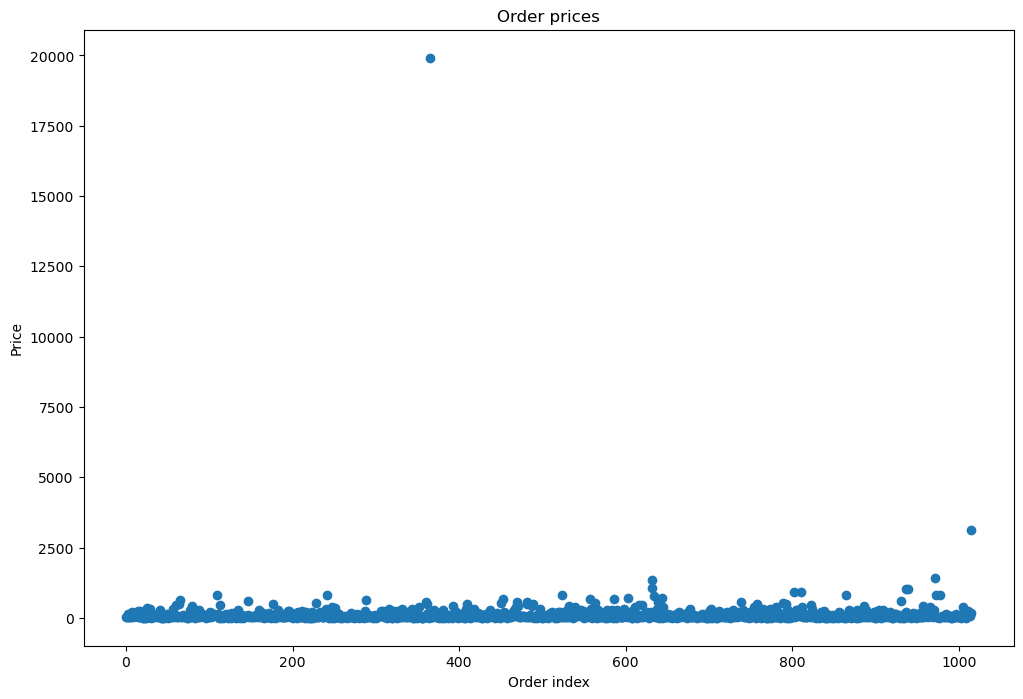

In [69]:
index = np.arange(len(orders['transactionId']))
plt.figure(figsize=(12,8))
plt.scatter(x=index,
            y=orders['revenue'])
plt.title('Order prices')
plt.xlabel('Order index')
plt.ylabel('Price');

In general, order prices seem to stay firmly below \\$1000. There is an order of \\$20000, likely the responsible of the jump that we have been observing.

[Back to Contents](#back)

### Order prices percentiles
<a name="order_prices_perc"></a>

Lets also check the percentiles to decide where to place the cutout point for declaring outliers.

In [41]:
np.percentile(orders['revenue'],[95, 99])

array([414.275, 830.3  ])

To get a clearer picture, lets check the percentiles on the users total spending during the test.

In [42]:
user_spending = orders.groupby('visitorId')['revenue'].sum().reset_index()

In [43]:
np.percentile(user_spending['revenue'], [95, 99])

array([449.5  , 912.576])

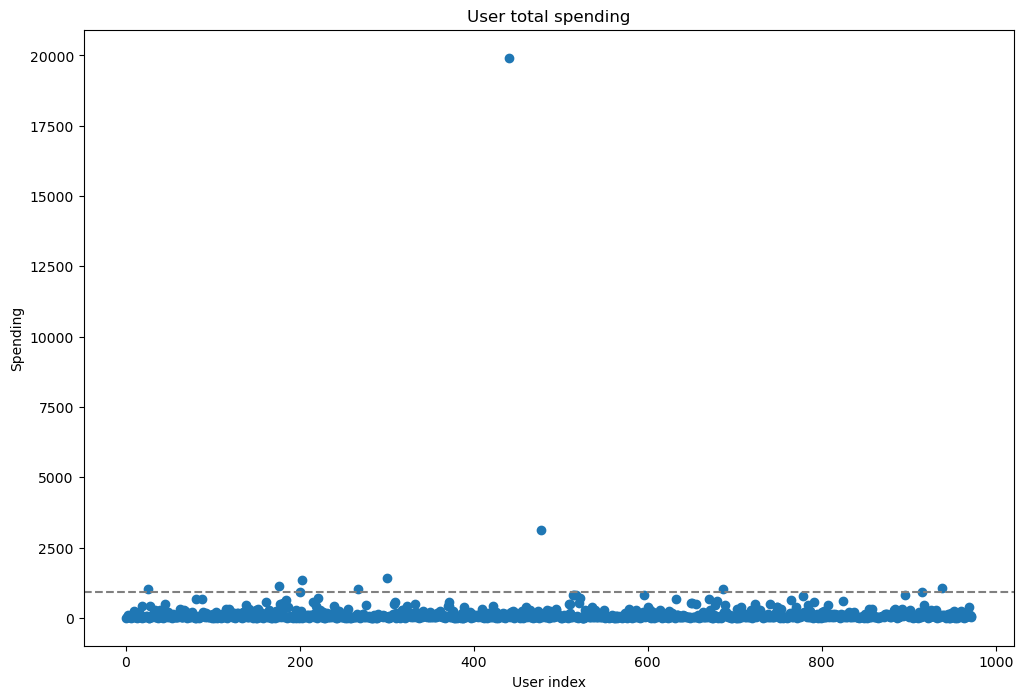

In [70]:
plt.figure(figsize=(12,8))
index=np.arange(len(user_spending['visitorId']))
plt.scatter(x=index,
            y=user_spending['revenue'])
plt.axhline(y=912, color='grey', linestyle='--')
plt.title('User total spending')
plt.xlabel('User index')
plt.ylabel('Spending');

There are two clear outlier clients, and a few that are slightly above the general population. This time we'll follow the percentile, and cut the top 1%. 

We'll set the outlier cutout point at \\$912.

In [45]:
# This df saves the IDs of the outlier users that we'll cut from the test. We'll use this later.
high_spenders = user_spending.query('revenue >= 912')['visitorId']

[Back to Contents](#back)

### Raw conversion difference significance
<a name="raw_conversion_difference_significance"></a>

Earlier we saw a small difference in conversion, favoring group A. Let's see if it is statistically significant.

First we'll create a function to do that.

In [46]:
def proportions_z_test(successes1, trials1, successes2, trials2, alpha):
    #Proportions of each group
    p1 = successes1 / trials1
    p2 = successes2 / trials2

    #Combined proportion
    pc = (successes1 + successes2) / (trials1 + trials2)
    
    dist = stats.norm(0,1)
    
    z = (p1 - p2) / math.sqrt(pc * (1 - pc) * (1/trials1 + 1/trials2))
    
    p = (1 - dist.cdf(abs(z))) * 2
    
    if p < alpha:
        print(f'Reject H0.\nP value: {p:0.5f}')
    else:
        print(f'Failed to reject H0.\nP value: {p:0.5f}')


Now lets test the hypothesis:<br>
H0: p1=p2<br>
HA: p1!=p2

In [47]:
successes1 = conversionA['orders'].max()
trials1 = conversionA['visits'].max()

successes2 = conversionB['orders'].max()
trials2 = conversionB['visits'].max()

alpha = 0.05

proportions_z_test(successes1, trials1, successes2, trials2, alpha)

Reject H0.
P value: 0.01685


We can reject the null hypotesis. The conversion advantage of group B is statistically significant.

[Back to Contents](#back)

### Significance of raw difference in average order sizes
<a name="significance_raw_difference_order_size"></a>

When we analized the difference in orders sizes for each group, we saw that the data was heavily influenced by outliers.

We'll check the statistic significance of the raw data, but we expect the filtered data to be much more enlightning.

In [48]:
alpha = 0.05

results = (
    stats.mannwhitneyu(
        orders.query('group == "A"')['revenue'],
        orders.query('group == "B"')['revenue']
    )
)

if (results[1] < alpha):
    print(f'Null hypothesis rejected. P value: {results[1]:0.3f}')
else:
    print(f'Failed to reject the null hypothesis. P value: {results[1]:0.3f}')


Failed to reject the null hypothesis. P value: 0.862


The raw data doesn't support the hypothesis that group B has a larger average check than group A.

[Back to Contents](#back)

### Significance of filtered difference in conversion
<a name="significance_filtered_difference_in_conversion"></a>

First we'll need to filter the data of abnormal users.

In [49]:
# There were no outliers based on amount of orders, only on order sizes. If there were, we would have to merge them.
# Right now, we can use the high_spenders Series to filter the data.
filtered_orders = orders[np.logical_not(orders['visitorId'].isin(high_spenders))]

We can filter the abnormal activity from `orders`, but not from `visits`. 

Now lets test the hypothesis with this filtered data.

H0: p1 = p2
HA: p1 != p2

In [50]:
successes1 = filtered_orders.query('group == "A"')['transactionId'].count()
trials1 = conversionA['visits'].max()

successes2 = filtered_orders.query('group == "B"')['transactionId'].count()
trials2 = conversionB['visits'].max()

alpha = 0.05

proportions_z_test(successes1, trials1, successes2, trials2, alpha)

Reject H0.
P value: 0.00851


Again we reject the null hypothesis. The conversion advantage of group B is statistically significant.

[Back to Contents](#back)

### Statistical significance of the difference of average orders using filtered data
<a name="significance_avg_check_filtered"></a>

Let's see if removing the outliers changes the outcome of the test.

In [51]:
alpha = 0.05

results=(
    stats.mannwhitneyu(
        filtered_orders.query('group == "A"')['revenue'],
        filtered_orders.query('group == "B"')['revenue']
    )
)

if (results[1] < alpha):
    print(f'Null hypothesis rejected. P value: {results[1]:0.3f}')
else:
    print(f'Failed to reject the null hypothesis. P value: {results[1]:0.3f}')

Failed to reject the null hypothesis. P value: 0.814


Removing the outliers made little difference in this case. We still failed to reject the null hypothesis.

It would be interesting to see how the average order look like without these outliers.

In [52]:
# Calculate the cumulative values per day for each group, this time using the filtered orders
filtered_cum_data = datesGroups.apply(
    lambda x: filtered_orders[
        np.logical_and(
            filtered_orders['date'] <= x['date'],
            filtered_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': get_group,
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum'
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])
filtered_cum_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

In [53]:
filtered_cum_revenueA = filtered_cum_data.query('group == "A"')[['date', 'revenue', 'orders']]
filtered_cum_revenueB = filtered_cum_data.query('group == "B"')[['date', 'revenue', 'orders']]

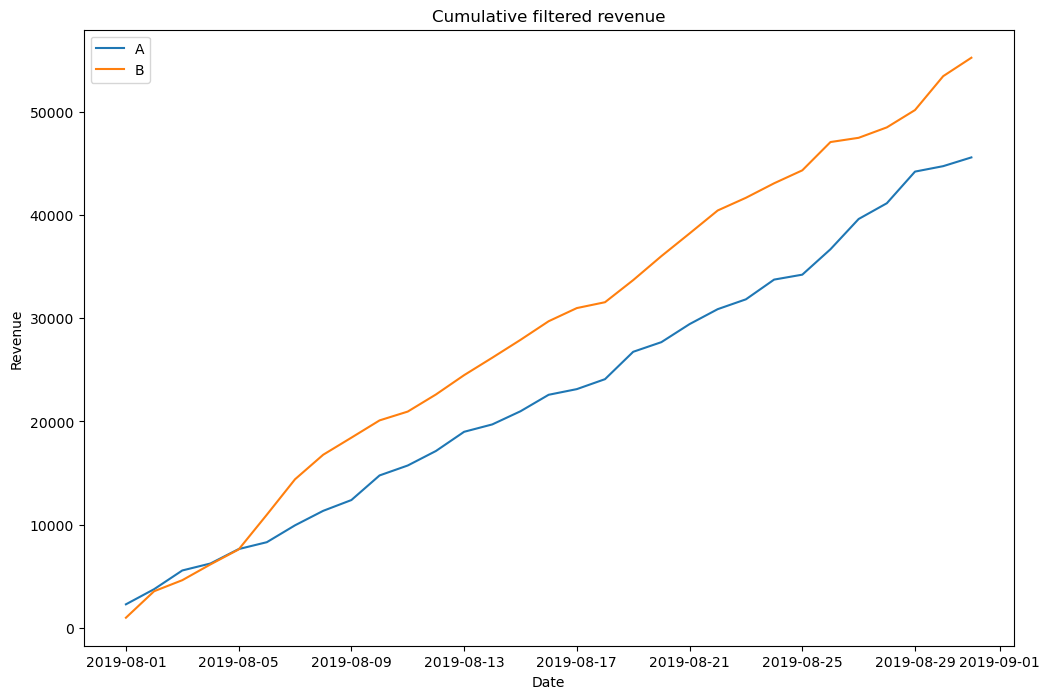

In [71]:
plt.figure(figsize=(12,8))

plt.plot(
    filtered_cum_revenueA['date'],
    filtered_cum_revenueA['revenue'],
    label="A"
)
plt.plot(
    filtered_cum_revenueB['date'],
    filtered_cum_revenueB['revenue'],
    label="B"
)
plt.title('Cumulative filtered revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.legend();

Without outliers, is clear that group B has a genuine advantage in total revenue.

In [55]:
print(filtered_cum_revenueA['revenue'].max())
print(filtered_cum_revenueB['revenue'].max())
print(filtered_cum_revenueB['revenue'].max() / filtered_cum_revenueA['revenue'].max())

45608.0
55275.100000000006
1.2119606209436942


The total revenue is about 20% higher for group B.

In [56]:
filtered_cum_revenueA['avg_order_size'] = filtered_cum_revenueA['revenue'] / filtered_cum_revenueA['orders']
filtered_cum_revenueB['avg_order_size'] = filtered_cum_revenueB['revenue'] / filtered_cum_revenueB['orders']

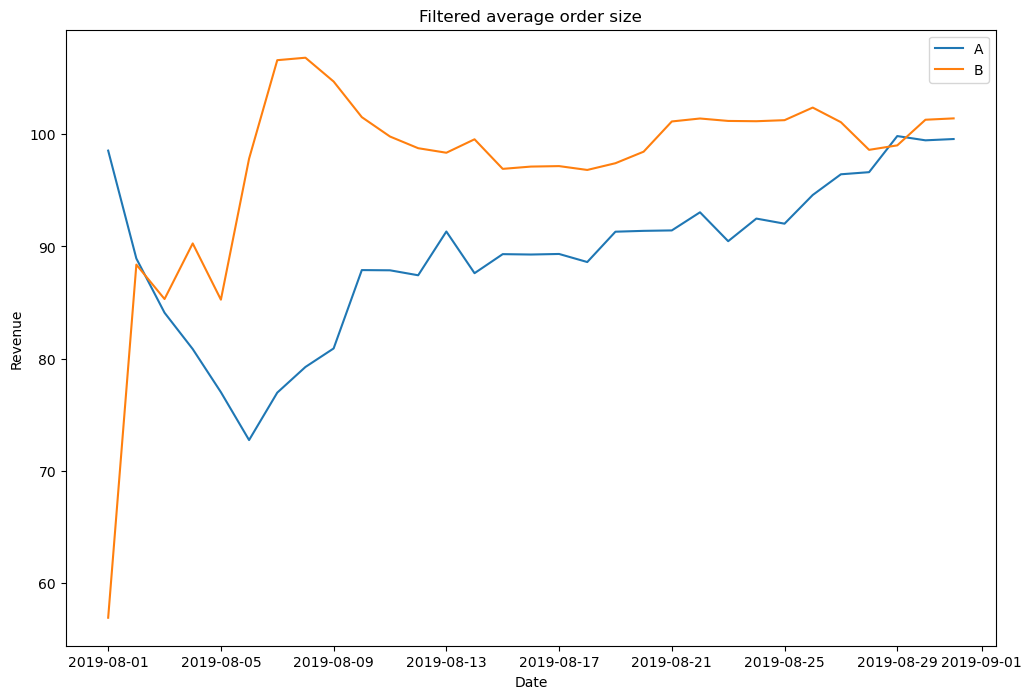

In [72]:
plt.figure(figsize=(12,8))
plt.plot(
    filtered_cum_revenueA['date'],
    filtered_cum_revenueA['avg_order_size'],
    label="A"
)

plt.plot(
    filtered_cum_revenueB['date'],
    filtered_cum_revenueB['avg_order_size'],
    label="B"
)
plt.title('Filtered average order size')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.legend();

Without the outliers, the groups are converging around $100.

The difference graph should show this clearly.

In [58]:
filtered_cum_revenue =(
    filtered_cum_revenueA.merge(
        filtered_cum_revenueB,
        on=['date'],
        suffixes=['A', 'B']
    )
)


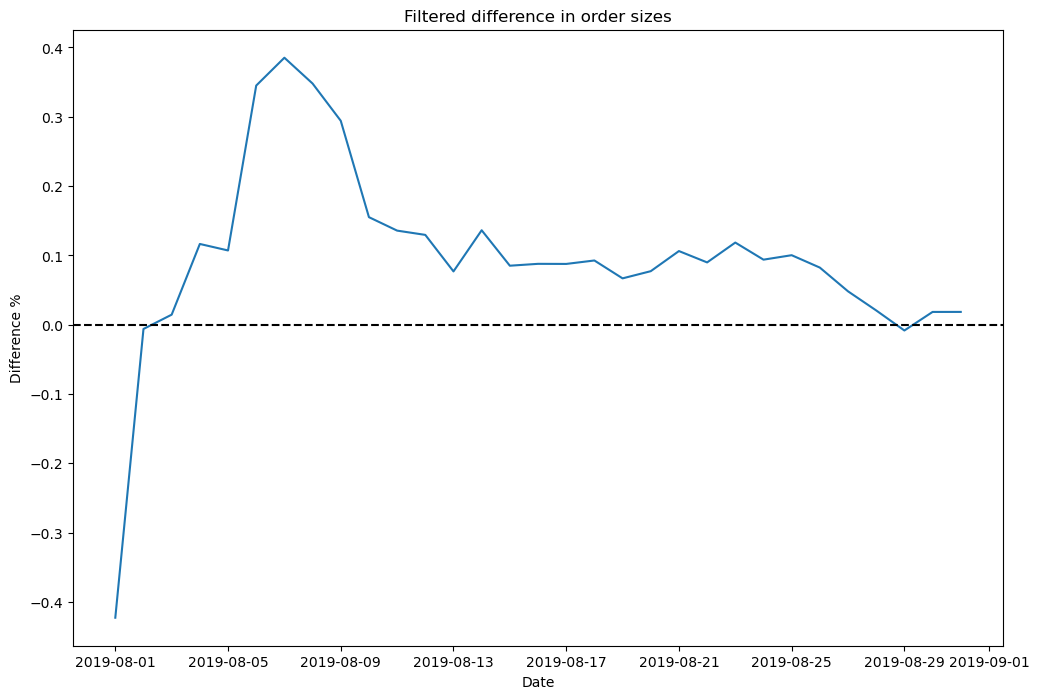

In [75]:
plt.figure(figsize=(12,8))

plt.plot(
    filtered_cum_revenue['date'],
    (filtered_cum_revenue['avg_order_sizeB'] / filtered_cum_revenue['avg_order_sizeA']) - 1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Filtered difference in order sizes')
plt.xlabel('Date')
plt.ylabel('Difference %');

After removing the outliers, the difference in average check is almost non-existant. It is not being affected by the test.

[Back to Contents](#back)

## Conclusion
<a name="final_decision"></a>

We have analyzed the test checking different metrics. These are the results:

- Cumulative Revenue: Group B increased revenue in 20%
- Average order size: There was no difference between groups.
- Conversion: There is a 15% improvement in conversion.

Based on this results, the recomendation is to stop the test, considering group B the leader.

[Back to Contents](#back)